 ### Análise não paramétrica e aplicação de random forest para dados de câncer de mama em mulheres

#### Título do banco de dados :Wisconsin Prognostic Breast Cancer (WPBC)

#### Criadores: 

	Dr. William H. Wolberg, General Surgery Dept., University of
	Wisconsin,  Clinical Sciences Center, Madison, WI 53792
	wolberg@eagle.surgery.wisc.edu

	W. Nick Street, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	street@cs.wisc.edu  608-262-6619

	Olvi L. Mangasarian, Computer Sciences Dept., University of
	Wisconsin, 1210 West Dayton St., Madison, WI 53706
	olvi@cs.wisc.edu 
    
#### Todas informações sobre o banco de dados ultilizado para as análises estão no link a seguir:
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    
#### Usarei para essa análise o título das variáveis em português para facilitar a leitura, mas no banco de dados original está tudo em inglês

##### Pacotes necessários para realizar as análises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import graphviz

In [2]:
#importando o banco de dados
df = pd.read_excel (r'dadoscancer.xlsx')

### Teste de wilcox e mannwhitneyu

#### Quando são obtidas pelo menos mensurações ordinais para as variáveis estudadas, o teste de Wilcoxon-Mann-Whitney, mais conhecido como soma de postos de Wilcoxon, pode ser usado para testar se dois grupos independentes foram extraídos de uma mesma população.

#### Este é um dos testes não paramétricos mais poderosos, sendo uma alternativa muito útil para o teste paramétrico t quando o pesquisador deseja evitar as suposições do teste t. No caso das variáveis desse banco de dados, nenhuma dupla seguiu distribuição normal de acordo com o teste de Shapiro-Wilk.

#### Suponha que tenhamos amostras de duas populações, X e Y .
#### A hipótese do teste é que a mediana de X é igual a mediana de Y , isto é:

$H_{0}: \tilde\mu_{x} = \tilde\mu_{y}$

#### Dessa forma, a hipótese alternativa pode ser denida como:
$H_{1} : \tilde\mu_{x} \neq \tilde\mu_{y}$ (bilateral), $H_{1} :\tilde\mu_{x} > \tilde\mu_{y}$ ou $H_{1} :\tilde\mu_{x} <\tilde\mu_{y}$, para o caso unilateral;

In [5]:
#fazendo o teste de wilcox e mannwhitneyu (bilateral) para todas as variáveis
#se o p-valor for maior do que 0.05 a mediana das variáveis de acordo com os diagnosticos não diferem

#discretizando as variáveis

Benignos = df.loc[df['diagnostico']=='B']
Malignos = df.loc[df['diagnostico']=='M']



pv=[]
for i in range(2,32):
    w, p = mannwhitneyu(Benignos.iloc[:,[i]],Malignos.iloc[:,[i]],alternative='two-sided')
    pv.append(p)

nomes = list(df.head(0))
pvaloreswilcox = pd.DataFrame(list(zip(nomes[2:],pv)), columns = ['Variáveis','pvalores'])

print(pvaloreswilcox)

             Variáveis      pvalores
0           media_raio  2.692943e-68
1        media_textura  3.428627e-28
2      media_perimetro  3.553870e-71
3           media_area  1.539780e-68
4      media_suavidade  7.793007e-19
5    media_compacidade  8.951992e-48
6    media_concavidade  2.164549e-68
7   media_pnt.concavos  1.006324e-76
8       media_simetria  2.268050e-15
9    media_dim.factral  5.371856e-01
10           errP_raio  6.217140e-49
11        errP_textura  6.436927e-01
12      errP_perimetro  5.099437e-51
13           errP_area  5.767823e-65
14      errP_suavidade  2.136316e-01
15    errP_compacidade  1.168061e-19
16    errP_concavidade  3.675508e-29
17   errP_pontconcavos  2.370852e-31
18       errP_simetria  2.783664e-02
19     errP_dimfactral  1.572165e-06
20           pior_raio  1.135630e-78
21        pior_textura  6.517718e-30
22      pior_perimetro  2.583004e-80
23           pior_area  1.803309e-78
24      pior_suavidade  3.637942e-24
25    pior_compacidade  2.115525e-47
2

#### As variáveis 'media_dim.factral', 'errP_textura','errP_suavidade' não são significativamente diferentes em relação ao tipo de diagnóstico, de acordo com o teste de wilcox e mannwhitneyu com um alpha = 0.05

#### dataframe com as variáveis estatísticamente iguais removidas

In [6]:
df1 = pd.DataFrame({'diagnostico':list(df.iloc[:,1]),'media_raio': list(df.iloc[:,2]), 'media_textura': list(df.iloc[:,3]),'media_perimetro':list(df.iloc[:,4]),
                   'media_area':list(df.iloc[:,5]),'media_suavidade':list(df.iloc[:,6]),'media_compacidade':list(df.iloc[:,7]),'media_concavidade':list(df.iloc[:,8]),
                   'media_pnt.concavos':list(df.iloc[:,9]),'media_simetria':list(df.iloc[:,10]),'errP_raio':list(df.iloc[:,12]),
                   'errP_perimetro':list(df.iloc[:,14]),'errP_area':list(df.iloc[:,15]),'errP_compacidade':list(df.iloc[:,17]),
                   'errP_concavidade':list(df.iloc[:,18]),'errP_pontconcavos':list(df.iloc[:,19]),'errP_simetria':list(df.iloc[:,20]),
                   'errP_dimfactral':list(df.iloc[:,21]),'pior_raio':list(df.iloc[:,22]),'pior_textura':list(df.iloc[:,23]),
                   'pior_perimetro':list(df.iloc[:,24]),'pior_area':list(df.iloc[:,25]),'pior_suavidade':list(df.iloc[:,26]),
                   'pior_compacidade':list(df.iloc[:,27]),'pior_concavidade':list(df.iloc[:,28]),'pior_pntconcavo':list(df.iloc[:,29]),
                   'pior_simetria':list(df.iloc[:,30]),'pior_dimfactral':list(df.iloc[:,30])})

#### verificando quais variáveis estão altamente correlacionadas, para evitar problemas de multicolinearidade
#### caso haja uma correlação maior do que .95, uma das variáveis altamente correlacionadas será removida do dataframe

In [7]:
corr = df1.iloc[:,1:].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,media_raio,media_textura,media_perimetro,media_area,media_suavidade,media_compacidade,media_concavidade,media_pnt.concavos,media_simetria,errP_raio,errP_perimetro,errP_area,errP_compacidade,errP_concavidade,errP_pontconcavos,errP_simetria,errP_dimfactral,pior_raio,pior_textura,pior_perimetro,pior_area,pior_suavidade,pior_compacidade,pior_concavidade,pior_pntconcavo,pior_simetria,pior_dimfactral
media_raio,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,0.68,0.67,0.74,0.21,0.19,0.38,-0.10,-0.04,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.16
media_textura,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,0.28,0.28,0.26,0.19,0.14,0.16,0.01,0.05,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.11
media_perimetro,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,0.69,0.69,0.74,0.25,0.23,0.41,-0.08,-0.01,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.19
media_area,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,0.73,0.73,0.80,0.21,0.21,0.37,-0.07,-0.02,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.14
media_suavidade,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.30,0.30,0.25,0.32,0.25,0.38,0.20,0.28,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.39
media_compacidade,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.50,0.55,0.46,0.74,0.57,0.64,0.23,0.51,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.51
media_concavidade,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.63,0.66,0.62,0.67,0.69,0.68,0.18,0.45,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.41
media_pnt.concavos,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.70,0.71,0.69,0.49,0.44,0.62,0.10,0.26,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.38
media_simetria,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,0.30,0.31,0.22,0.42,0.34,0.39,0.45,0.33,0.19,0.09,0.22,0.18,0.43,0.47,0.43,0.43,0.70,0.70
errP_raio,0.68,0.28,0.69,0.73,0.30,0.50,0.63,0.70,0.30,1.00,0.97,0.95,0.36,0.33,0.51,0.24,0.23,0.72,0.19,0.72,0.75,0.14,0.29,0.38,0.53,0.09,0.09


In [8]:
#dataframe com variáveis altamente relacionadas removidas (uma das variáveis da dupla para o calculo da correlação)
df1 = df1.drop(columns=['media_area','pior_raio','media_perimetro','pior_perimetro','pior_area','media_textura','errP_perimetro',
                       'errP_area','pior_dimfactral'])

In [9]:
corr = df1.iloc[:,1:].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,media_raio,media_suavidade,media_compacidade,media_concavidade,media_pnt.concavos,media_simetria,errP_raio,errP_compacidade,errP_concavidade,errP_pontconcavos,errP_simetria,errP_dimfactral,pior_textura,pior_suavidade,pior_compacidade,pior_concavidade,pior_pntconcavo,pior_simetria
media_raio,1.00,0.17,0.51,0.68,0.82,0.15,0.68,0.21,0.19,0.38,-0.10,-0.04,0.30,0.12,0.41,0.53,0.74,0.16
media_suavidade,0.17,1.00,0.66,0.52,0.55,0.56,0.30,0.32,0.25,0.38,0.20,0.28,0.04,0.81,0.47,0.43,0.50,0.39
media_compacidade,0.51,0.66,1.00,0.88,0.83,0.60,0.50,0.74,0.57,0.64,0.23,0.51,0.25,0.57,0.87,0.82,0.82,0.51
media_concavidade,0.68,0.52,0.88,1.00,0.92,0.50,0.63,0.67,0.69,0.68,0.18,0.45,0.30,0.45,0.75,0.88,0.86,0.41
media_pnt.concavos,0.82,0.55,0.83,0.92,1.00,0.46,0.70,0.49,0.44,0.62,0.10,0.26,0.29,0.45,0.67,0.75,0.91,0.38
media_simetria,0.15,0.56,0.60,0.50,0.46,1.00,0.30,0.42,0.34,0.39,0.45,0.33,0.09,0.43,0.47,0.43,0.43,0.70
errP_raio,0.68,0.30,0.50,0.63,0.70,0.30,1.00,0.36,0.33,0.51,0.24,0.23,0.19,0.14,0.29,0.38,0.53,0.09
errP_compacidade,0.21,0.32,0.74,0.67,0.49,0.42,0.36,1.00,0.80,0.74,0.39,0.80,0.14,0.23,0.68,0.64,0.48,0.28
errP_concavidade,0.19,0.25,0.57,0.69,0.44,0.34,0.33,0.80,1.00,0.77,0.31,0.73,0.10,0.17,0.48,0.66,0.44,0.20
errP_pontconcavos,0.38,0.38,0.64,0.68,0.62,0.39,0.51,0.74,0.77,1.00,0.31,0.61,0.09,0.22,0.45,0.55,0.60,0.14


#### Agora vamos aplicar o modelo random forest e verificar quais variáveis mais afetam no diagnóstico de câncer de mama


#### Primeiramente faremos uma análise gráfica para visualizar qual a proporção dos tipos de diagnóstico. Esse gráfico de setores será necessário para verificarmos se o banco de dados necessita de uma transformação de oversampling.

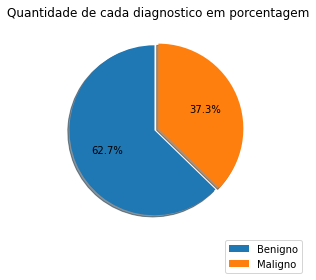

In [10]:

#Plotando um gráfico de setores para visualizar a proporção de cada tipo de diagnóstico
B = len(Benignos['diagnostico'])
M = len(Malignos['diagnostico'])
Diagquant = [B,M]
Diagnomes = ['Benigno','Maligno']
explode = (0.05,0)
plt.title('Quantidade de cada diagnostico em porcentagem')

plt.pie(Diagquant,explode=explode,autopct='%1.1f%%',shadow=True, startangle=90)

plt.legend(Diagnomes,bbox_to_anchor=(1.2, 0),loc='upper right')
plt.tight_layout()
plt.show()

#### Como a proporção dos tipos de diagnósticos é significativamente diferente, irei realizar uma transformação de oversampling, que é basicamente adicionar dados semelhantes ao diagnóstico do tipo Maligno, até que tenhamos a mesma quantidade de observações Benignas e Malignas

In [11]:
#separando dados e suas classes
X = df1.iloc[:,1:]
y = df1.diagnostico

#oversampling com o pacote SMOTE
smt = SMOTE()

#fazendo o oversampling
X, y = smt.fit_resample(X, y)

#### Verificando graficamente a nova proporção dos tipos de diagnósticos

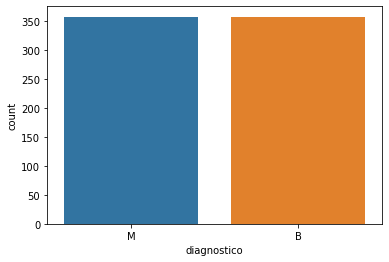

In [12]:
ax = sns.countplot(x=y)

In [13]:
#separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=0.3 , train_size=0.7)

In [49]:
### arvore de decisao com profundidade igual a 5. Sinta-se livre para mudar esssa e outras métricas para esse modelo.
clf = DecisionTreeClassifier(max_depth=5,criterion='entropy')
clf = clf.fit(X_train,y_train)

In [50]:
#coloca as classificacoes na variavel y_pred
y_pred = clf.predict(X_test)

In [51]:
#checando a acuracia do modelo

accuracy_score(y_test,y_pred)

0.9255813953488372

In [52]:
#relatorio de classificacao
#Observe o recall

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           B       0.93      0.93      0.93       107
           M       0.93      0.93      0.93       108

    accuracy                           0.93       215
   macro avg       0.93      0.93      0.93       215
weighted avg       0.93      0.93      0.93       215



# Sobre as métricas

#### .Precisão: dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
#### .Recall: dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
#### .F1-Score: média harmônica entre precisão e recall.

In [53]:
#Vamos ver quais variáveis foram as mais importantes para o aprendizado do modelo
k=clf.feature_importances_
vi=[]

for float in k:
    vi.append(float)

nomes = list(df1.head(0))
variaveisimp = pd.DataFrame(list(zip(nomes[1:],vi)), columns = ['Variáveis','importância'])

print(variaveisimp)

             Variáveis  importância
0           media_raio     0.117544
1      media_suavidade     0.000000
2    media_compacidade     0.000000
3    media_concavidade     0.000000
4   media_pnt.concavos     0.578890
5       media_simetria     0.000000
6            errP_raio     0.024373
7     errP_compacidade     0.000000
8     errP_concavidade     0.000000
9    errP_pontconcavos     0.000000
10       errP_simetria     0.000000
11     errP_dimfactral     0.000000
12        pior_textura     0.156713
13      pior_suavidade     0.055086
14    pior_compacidade     0.007373
15    pior_concavidade     0.000000
16     pior_pntconcavo     0.043139
17       pior_simetria     0.016882


### Gráfico de barras para facilitar visualização das variáveis importantes

<BarContainer object of 18 artists>

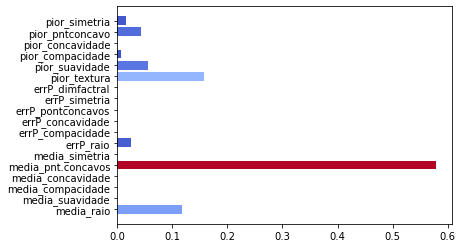

In [54]:
my_cmap = plt.get_cmap("coolwarm")
y=variaveisimp.loc[:,'importância']

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

plt.barh(variaveisimp.loc[:,'Variáveis'],variaveisimp.loc[:,'importância'],color=my_cmap(rescale(y)))

### Gráfico da árvore de decisão

In [55]:
do_data = export_graphviz(clf,feature_names=X[['media_raio','media_suavidade','media_compacidade','media_concavidade','media_pnt.concavos','media_simetria','errP_raio','errP_compacidade','errP_concavidade','errP_pontconcavos','errP_simetria','errP_dimfactral','pior_textura','pior_suavidade','pior_compacidade','pior_concavidade','pior_pntconcavo','pior_simetria']].columns,
                          class_names = ['0','1'],filled=True,special_characters=True)

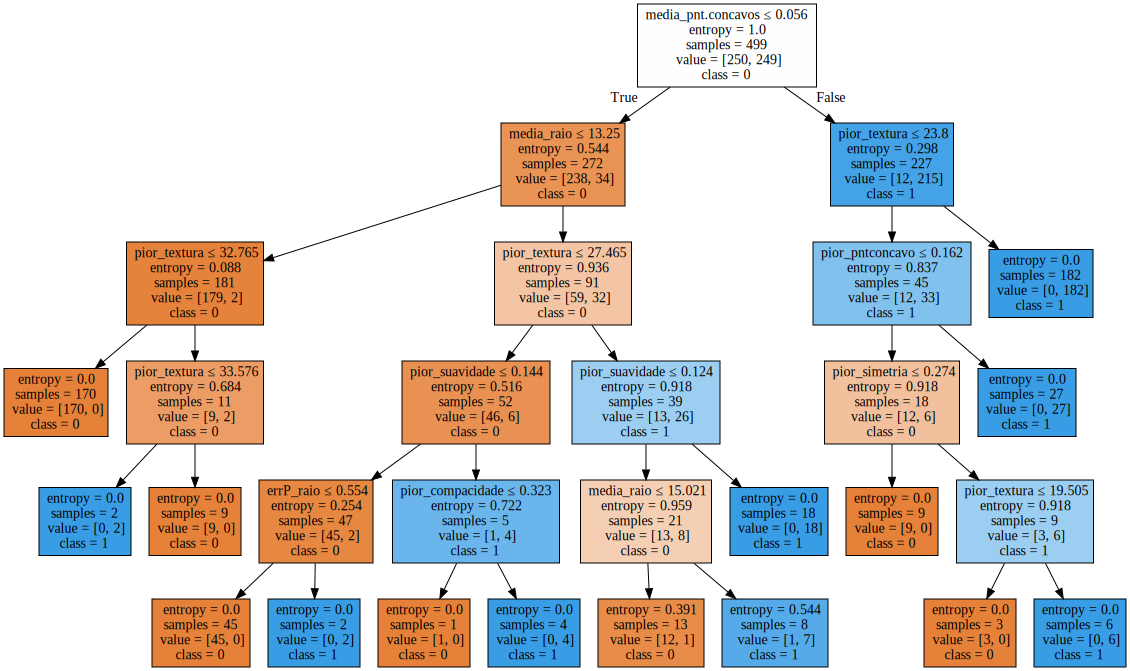

In [56]:
graph = graphviz.Source(do_data)
graph

# Conclusão

### O modelo de árvore de decisão parece ter se adequado bem aos dados. Apesar das métricas de precisão, acurácia e recall serem maior do que 90%, não se engane! Pode haver overfitting nos dados. O ideal seria um banco de dados ainda maior para validação. Apesar dessa suspeita os resultados foram excelentes.




#### Qualquer crítica é bem vinda!